In [1]:
import tensorflow as tf
import numpy as np
from random import randint
import matplotlib.pyplot as plt

import tensorflow_nn

%matplotlib inline

In [2]:
tf.reset_default_graph()

In [3]:
num_neurons = 125
iterations = 5000

### Defining connections

In [4]:
num_of_e_neurons = 100
num_of_i_neurons = 25

connections = []
connection_weights = []
for i in range(num_neurons):
    temp_conns = []
    temp_weights = []

    if i < num_of_e_neurons:
        for j in range(num_of_e_neurons):
            number = randint(0, 99)
            if (i != j) and (number < 10):
                temp_conns.append(j*1.0)
                temp_weights.append(0.1)
        for j in range(num_of_e_neurons, num_of_e_neurons + num_of_i_neurons):
            number = randint(0, 99)
            if (i != j) and (number < 10):
                temp_conns.append(j*1.0)
                temp_weights.append(0.1)
    else:
        for j in range(num_of_e_neurons):
            number = randint(0, 99)
            if (i != j) and (number < 15):
                temp_conns.append(j*1.0)
                temp_weights.append(0.1)
                
    connections.append(temp_conns)
    connection_weights.append(tf.Variable(np.asarray(temp_weights), dtype=tf.float32))

### Defining initial state

In [5]:
inputs = tf.Variable(np.array([[0.]*(num_neurons)] * iterations))

ve_initial = tf.Variable(np.array([-40.]*num_of_e_neurons), dtype=tf.float32)

vi_initial = tf.Variable(np.array([-40.]*num_of_i_neurons), dtype=tf.float32)

ve_fired_initial = tf.zeros(num_of_e_neurons)
ve_fired_iteration = tf.zeros(num_of_e_neurons)

vi_fired_initial = tf.zeros(num_of_i_neurons)
vi_fired_iteration = tf.zeros(num_of_i_neurons)

initial_state = tensorflow_nn.BNNState(
    rk_variables=[[ve_initial], [vi_initial]],
    iteration=tf.Variable(0.), fired=[ve_fired_initial, vi_fired_initial],
    fired_iteration=[ve_fired_iteration, vi_fired_iteration])

### Defining custom current functions

In [6]:
def current_func(rk_variables, iteration, fired, fired_iteration, step_input, connections, connection_weights):
    [[ve], [vi]] = rk_variables
    [ve_fired, vi_fired] = fired
    [ve_fired_iter, vi_fired_iter] = fired_iteration
    
    #e type neurons
    ve_new = fIl_ve(ve)
    
    #i type neurons
    vi_new = fIl_vi(vi)
    
    #synapse calculation
    ## ...for loop for each type of connection and each type of input.....
    v = tf.concat([ve, vi], 0)
    fired = tf.concat([ve_fired, vi_fired], 0)
    fired_iteration = tf.concat([ve_fired_iteration, vi_fired_iteration], 0)
    ve_syn, vi_syn = fIs(v, iteration, fired, fired_iteration, connections, connection_weights)
    
    return [[tf.add(ve_new,ve_syn)], [tf.add(vi_new,vi_syn)]]


v_e = tf.Variable(np.random.normal(-65., 0.001, num_of_e_neurons), dtype=tf.float32)
gl_e = tf.Variable(np.random.normal(0.02, 0.001, num_of_e_neurons), dtype=tf.float32)
dc_e_list = [0.] * num_of_e_neurons
dc_e_list[0] = 0.5
dc_e = tf.Variable(np.asarray(dc_e_list), dtype=tf.float32)

def fIl_ve(ve):
    ve_new = tf.add(tf.multiply(gl_e, tf.subtract(v_e, ve)), dc_e)
    return ve_new


v_i = tf.Variable(np.random.normal(-65., 0.001, num_of_i_neurons), dtype=tf.float32)
gl_i = tf.Variable(np.random.normal(0.02, 0.001, num_of_i_neurons), dtype=tf.float32)

dc_i_list = [0.] * num_of_i_neurons
dc_i = tf.Variable(np.asarray(dc_i_list), dtype=tf.float32)

def fIl_vi(vi):
    vi_new = tf.add(tf.multiply(gl_i, tf.subtract(v_i, vi)), dc_i)
    return vi_new



#####################################################################
##      Syanapse Current Calculations                              ##
#####################################################################

tau = tf.constant(10000.)
vs_ampa = tf.constant(0.) 
vs_gaba = tf.constant(-90.)

ampa_indices_list = []
gaba_indices_list = []
for i in range(num_neurons):
    ampa_temp = []
    gaba_temp = []
    for index in connections[i]:
        if index < num_of_e_neurons:
            ampa_temp.append(index)
        else:
            gaba_temp.append(i)
    ampa_indices_list.append(tf.Variable(np.asarray(ampa_temp), dtype=tf.int32))
    gaba_indices_list.append(tf.Variable(np.asarray(gaba_temp), dtype=tf.int32))

def fIs(v, iteration, fired, fired_iteration, connections, connection_weights):
    v_ampa = tf.multiply(tf.exp(tf.divide(tf.subtract(iteration, fired_iteration), tau)), tf.subtract(vs_ampa, v))
    v_gaba = tf.multiply(tf.exp(tf.divide(tf.subtract(iteration, fired_iteration), tau)), tf.subtract(vs_gaba, v))
    
    mul_product = []
    for i in range(num_neurons):
        #ampa synapses
        ampa_indices = ampa_indices_list[i]
        ampa_gather = tf.reduce_sum(tf.gather(tf.multiply(v_ampa, 0.01 * fired), ampa_indices))

        #gaba synapses
        gaba_indices = gaba_indices_list[i]
        gaba_gather = tf.reduce_sum(tf.gather(tf.multiply(v_gaba, 0.01 * fired), gaba_indices))

        mul_product.append(tf.add(ampa_gather, gaba_gather)) 

    return [tf.stack(mul_product[0: num_of_e_neurons], 0), tf.stack(mul_product[num_of_e_neurons:], 0)]

### Instantiate and run the simulation

In [7]:
bnn = tensorflow_nn.TFBNN(
    num_neurons=num_neurons, iterations=iterations, h=tf.constant(0.01), firing_threshold=tf.constant(0.),
    firing_reset=tf.constant(-65.), current_func=current_func, initial_state=initial_state,
    inputs=inputs, connections=connections, connection_weights=connection_weights
)

In [8]:
%%time
output = bnn.run_simulation()

CPU times: user 1min 59s, sys: 2min 7s, total: 4min 7s
Wall time: 2min 4s


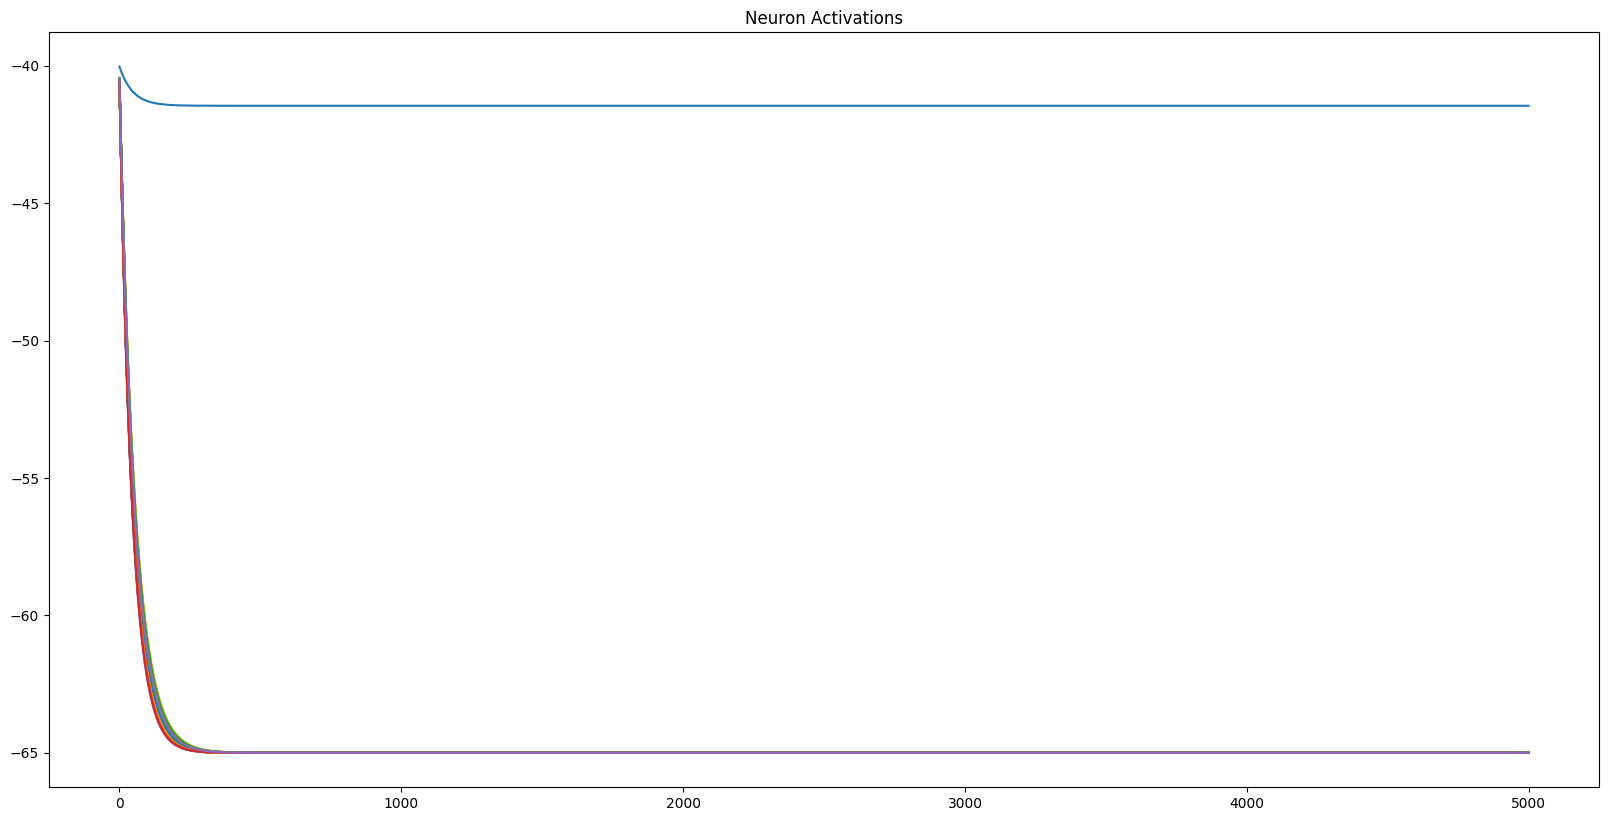

In [9]:
plt.figure(figsize=(20,10))
plt.title('Neuron Activations')

for i in range(num_of_e_neurons):
    plt.plot([y[i] for y in output[0][0][0]], label='v'+str(i+1))

for i in range(num_of_i_neurons):
    plt.plot([y[i] for y in output[0][1][0]], label='v'+str(i+100))

plt.show()